# Class Workbook {.tabset .tabset-fade .tabset-pills}

In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib.pyplot import subplots
#import statsmodels.api as sm
from plotnine import *
import plotly.express as px
import statsmodels.formula.api as sm
#import ISLP as islp

## Ames Housing data

We will look at the Ames Housing data.  The task is to predict the houses after 2008 based on data up to 2008.

In [3]:
ames_raw=pd.read_csv("ames_raw.csv")
ames_raw_2009, ames_raw_2008= ames_raw.query('`Yr Sold`>=2008').copy(), ames_raw.query('`Yr Sold` <2008').copy()

The loss will be the same as before. If your algorithm decides to pay more than the actual price your company buys. If the predicted price is lower, your company will fail to buy.

- If you bought for more than the actual value, you’ve overpaid.
- If you bid less and lost, you lost a profit of 10% of the house price.

In [4]:
def calc_loss(prediction,actual):
  difpred = actual-prediction
  RMSE =pow(difpred.pow(2).mean(),1/2)
  operation_loss=abs(sum(difpred[difpred<0]))+sum(0.1*actual[difpred>0])
  return RMSE,operation_loss

## Feature engineering

### Types of Feature engineering
There are several categories of feature engineering.

1. Adding information from other sources
2. Missing Data Handling
3. Dealing with problematic values (outliers, inliers, etc)
4. Making variables that make sense for the context
5. Transformation
6. Scaling
7. Discretization

### 1. Adding information from other sources

When handed a dataset, it's easy to jump right into the analysis.  This is typical behavior, especially for a novice.  However, there is often information that could be explored if you know what you are looking for.  There are a few categories of such information.

a) Information that was not given to you but someone has access to.

When you are not the data creator, sometimes you are not given access to certain information.  The most common is information that pertains to privacy or protected attributes.  This information is often not given to you for reasons external to the project you are working on.  However, in certain circumstances, if you know what you are looking for, you might be able to negotiate information that could save you some headaches down the line. Think outside the box and be creative.  The important caveat is that obtaining some information could have legal consequences.  Web scraping and other means of data collection should be done with care.  Some industry such as pharmacies have strict rule that prohibits the use of pharmacy information for their retail purpose.

b) Information that is public but you need to obtain.

There are information about places and things on the internet that are easy to incorporate.
For example, in housing data, geographic information could be tied to census information.  Financial information might require adjusting for inflation, which again can be found on the internet.  Other survey information might be available if you care to look for them.  One thing to be careful is that not all information that you can find will be useful.  You need to balance the time needed vs the benefit of the information.

c) Information that is confusing for machines

Coded variables without keys do not make sense but for a computer they seem like a numeric variable.  If not careful, one might include them as numeric.  Take `MS SubClass`, which codes the building class.

In [5]:
ames_raw.loc[:,"MS SubClass"].value_counts()

20     1079
60      575
50      287
120     192
30      139
160     129
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MS SubClass, dtype: int64

Unfortunately, the help file does not contain detailed information on the codes.  But with some research you will be able to [find](https://github.com/zzeniale/Ames-housing-price-prediction) that codes do not have ordering to them.  Therefore, you need to think carefully about what matters and then discretize the variable in some ways.

  - 20 1-STORY 1946 & NEWER ALL STYLES
  - 30 1-STORY 1945 & OLDER
  - 40 1-STORY W/FINISHED ATTIC ALL AGES
  - 45 1-1/2 STORY - UNFINISHED ALL AGES
  - 50 1-1/2 STORY FINISHED ALL AGES
  - 60 2-STORY 1946 & NEWER
  - 70 2-STORY 1945 & OLDER
  - 75 2-1/2 STORY ALL AGES
  - 80 SPLIT OR MULTI-LEVEL
  - 85 SPLIT FOYER
  - 90 DUPLEX - ALL STYLES AND AGES
  - 120 1-STORY PUD (Planned Unit Development) - 1946 & NEWER
  - 150 1-1/2 STORY PUD - ALL AGES
  - 160 2-STORY PUD - 1946 & NEWER
  - 180 PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
  - 190 2 FAMILY CONVERSION - ALL STYLES AND AGES

### 2. Missing Data Handling

To handle missing data, it's always essential to consider the context.  Data that is missing is not by themselves a problem.  The fundamental problem is the bias that these variable might pose down the line if incorporated.  Doing a careful imputation takes effort.  When time is of a concern, deleting variables with high rate of missingness should be considered.

a) Missing data that is not really missing
Variable such as `Garage Yr Blt` has 159 observations missing.  But if you look carefully, you will realize that the houses that are missing this information are the ones that have no garage.  This is not missing data but a coding problem.  One must decide what to do with such information based on the context.  You should not fill such missingness with some arbitrary number.

In [6]:
ames_raw.loc[np.isnan(ames_raw.loc[:,"Garage Yr Blt"]),"Garage Cars"]

27      0.0
119     0.0
125     0.0
129     0.0
130     0.0
       ... 
2913    0.0
2916    0.0
2918    0.0
2919    0.0
2927    0.0
Name: Garage Cars, Length: 159, dtype: float64

b) Missing data that is too big
Some variables might have too much missing data, and there may be a good reason for that.  If there are ways to craft a variable that could serve as a proxy for such information, one should try.  But if such effort introduces additional uncertainty, one might remove the variable altogether.

In [7]:
missing_data_proportion = ames_raw.isna().mean()

In [ ]:
missing_data_proportion.iloc[np.where(missing_data_proportion>0.1)]
import matplotlib.pyplot as plt

plt.scatter(np.argsort(missing_data_proportion), missing_data_proportion,marker='o')
# naming the x axis
plt.xlabel("order")
# naming the y axis
plt.ylabel('proportion missing')
# giving a title to my graph
plt.title('Missing data proportion')
# function to show the plot
plt.show()

c) Missing data that could be an additional information

If missingness is intentional, one might add a variable to signify such missingness.  You will need to fill the missing value with some value, which depends on the variable.

d) Missing completely at random (MCAR)

If MCAR, one could remove the rows with missingness without introducing bias.  However, this is a strong assumption that is often not met in practice.

e) Missing at Random (MAR)

For MAR, regression-based imputation often is used.  Many packages allow you to do these imputations reasonably easily.  However, one thing that you will need to think about is that some imputation method will work better after transformation then before.  This will rely on the model being used to impute.  See `mi`, `mice`, etc for detail.

f) Missing not at random (MNAR)

MNAR variable is hard to deal with. One needs to weigh the cost and benefit of including such variables.  An example of such is a variable like income.  If all the low-income people are not responding, one might use a small number as a proxy.  But if there are reasons to believe there multiple categories of cause they are missing, and there is no way to tell, then you might be better off removing the variable.

### 3. Dealing with problematic values (outliers, inliers, etc)

Problematic observations such as outliers are hard to find and often require you to revisit this step a few times.  This is important because you must deal with them before applying transformations.  For example, outliers would distort statistics such as means which would be problematic if you plan to use z-score transformation.  When you have a lot of zeros, this could impact how you want to transform a variable.  EDA often finds outliers, but they may not pop up until the modeling phase.  Truncating or removing data with outliers should be done with caution since they often introduce an unwanted feature in the data.

Here is an illustration of two types of outliers that are harder and easier to find.

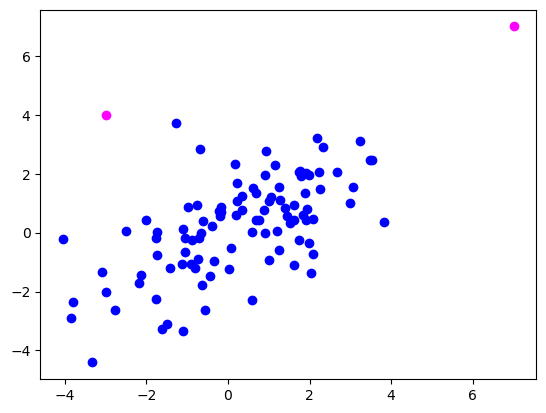

In [8]:
from scipy.stats import multivariate_normal
dat=multivariate_normal([0, 0], [[3.0, 2.0], [2.0, 3.0]]).rvs(100)
dat=np.vstack([dat,[7.0,7.0],[-3.0,4.0]])
import matplotlib.pyplot as plt

col=[]
for i in range(100):
  col.append("blue")


col.append("magenta")
col.append("magenta")

for i in range(102):
    plt.scatter(dat[i,0],dat[i,1],marker='o',color=col[i])

plt.show()

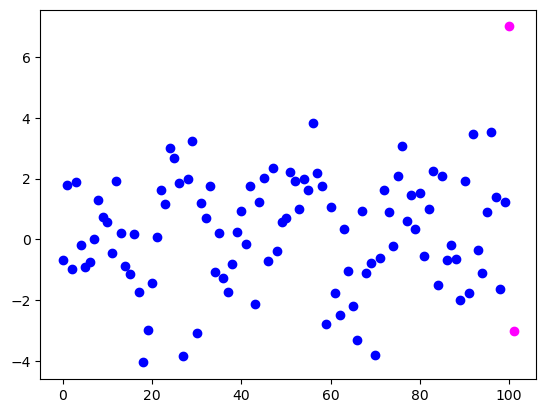

In [9]:
xx=range(0, 102,1)
for i in range(102):
    plt.scatter(xx[i],dat[i,0],marker='o',color=col[i])


plt.show()

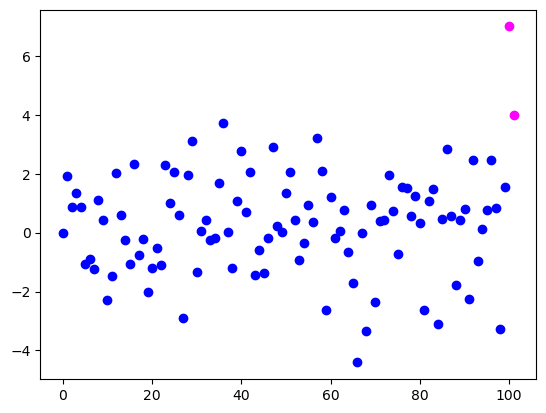

In [10]:
for i in range(102):
    plt.scatter(xx[i],dat[i,1],marker='o',color=col[i])

plt.show()

Look at the basement and the 2nd floor Square footage, you can see that there are bimodality as well as properties that have outliers.  This should make you cautious of performing scaling to these variables.

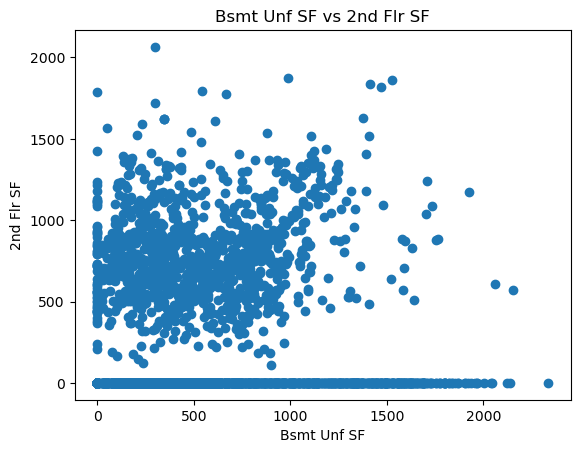

In [11]:
import matplotlib.pyplot as plt
plt.scatter(ames_raw.loc[:,"Bsmt Unf SF"], ames_raw.loc[:,"2nd Flr SF"],marker='o')
# naming the x axis
plt.xlabel("Bsmt Unf SF")
# naming the y axis
plt.ylabel('2nd Flr SF')

# giving a title to my graph
plt.title('Bsmt Unf SF vs 2nd Flr SF')

# function to show the plot
plt.show()

# plot(ames_raw$`Bsmt Unf SF`,ames_raw$`2nd Flr SF`)

### 4. Making variables that make sense for the context

Context matters when doing feature engineering.  Take, for example, the Ames housing data.  Ames is a university town where many people have some ties to the university of Iowa.  Therefore, looking at things like distance from the university might make sense to include in the analysis.  Another thing to think about is things like the Year built. The impact of the year built is not absolute and shifts over the years.  Therefore one might want to make a variable that is the age of the house at sales.

In [13]:
# handling Year features
ames_raw["yrs_since_remod"]=  ames_raw.loc[:,"Yr Sold"] -  ames_raw.loc[:,"Year Remod/Add"]

# Total Living Area
ames_raw["TotalArea"] =ames_raw.loc[:,"Gr Liv Area"] +  ames_raw.loc[:,"Total Bsmt SF"]

# TotalBath
ames_raw["TotalBath"] =ames_raw.loc[:,"Bsmt Full Bath"] + 0.5 * ames_raw.loc[:,"Bsmt Half Bath"]+ames_raw.loc[:,"Full Bath"] + 0.5 * ames_raw.loc[:,"Half Bath"]

### 5. Transformation

When the predictor is right skewed they tend to distort the linear model by exhibiting leverage points.  Taking a log will resolve such a problem.

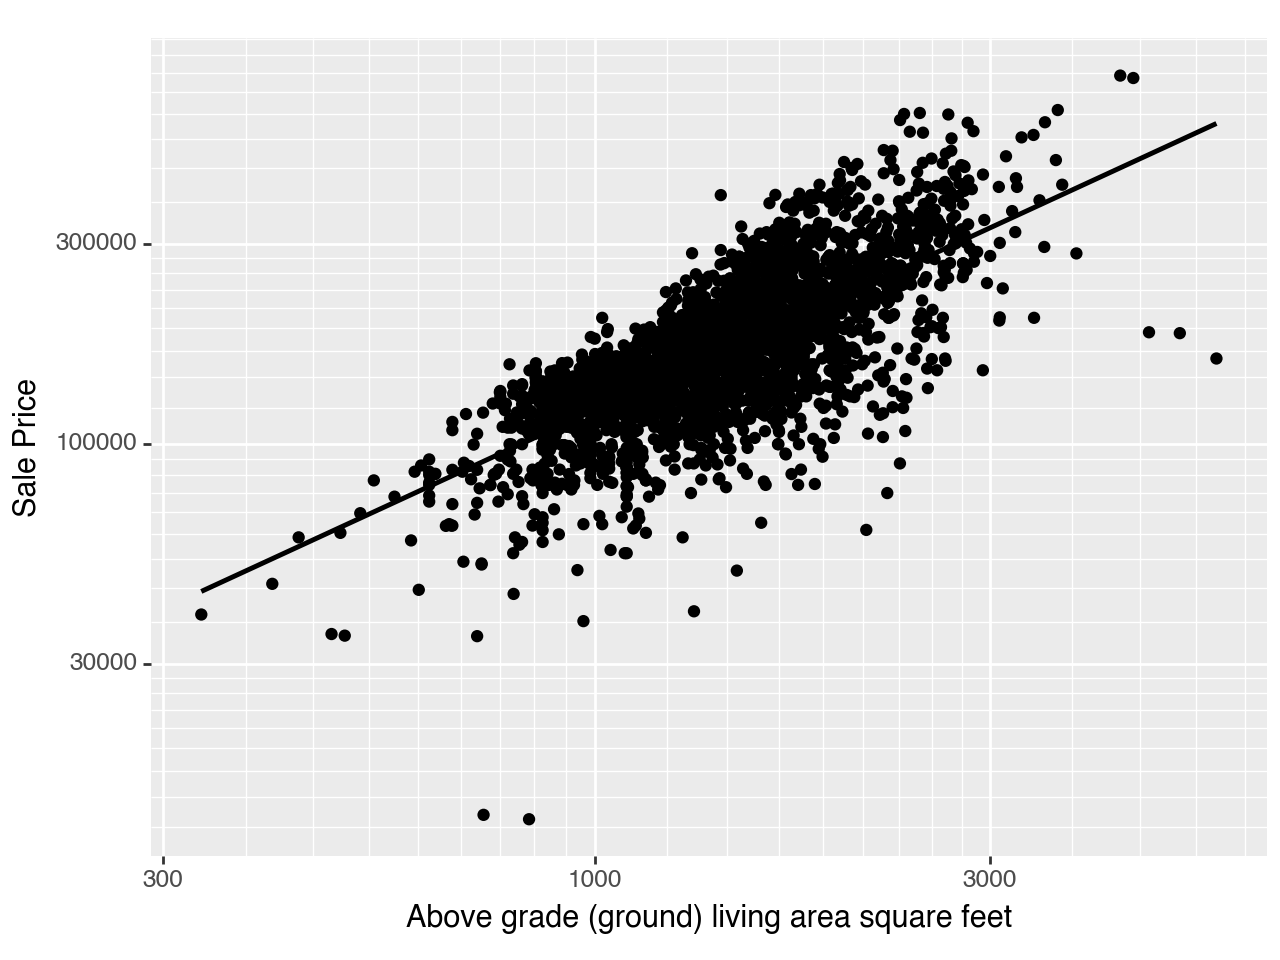

<Figure Size: (640 x 480)>

In [14]:
(
  ggplot(ames_raw)+geom_point()+aes(x="Gr Liv Area",y="SalePrice")+xlab("Above grade (ground) living area square feet")+ylab("Sale Price")+geom_smooth(method="lm",se=False)
)
(
ggplot(ames_raw)+geom_point()+aes(x="Gr Liv Area",y="SalePrice")+xlab("Above grade (ground) living area square feet")+ylab("Sale Price")+geom_smooth(method="lm",se=False)+scale_y_log10()+scale_x_log10()
)

### 6. Scaling, centering and normalizing.

For linear regression models, centering and scaling does not change the model itself, but they change the interpretability of the model coefficients. Converting all the predictors on a similar scale has its advantage because the size of the coefficient will directly indicate the influence of the predictor. For some hierarchical models, scaling will also help with the convergence problem. But scaling is critical for all the distance-based methods you will encounter later in the semester.

### 7. Discretization

Categorical variables need to be coded appropriately.  Dummy coding or one-hot-encoding is one way when the information is nominal.  Take, for example, the building type variable by default, it's a character variable with five values.

In [15]:
ames_raw.loc[:,"Bldg Type"].value_counts()

1Fam      2425
TwnhsE     233
Duplex     109
Twnhs      101
2fmCon      62
Name: Bldg Type, dtype: int64

One can use contextual information to convert them into meaningful variables like a single family and multiple families or a shared house.  Or use dummy coding.

In [16]:
pd.get_dummies(ames_raw.loc[:,"Bldg Type"])

,1Fam,2fmCon,Duplex,Twnhs,TwnhsE
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
2925,1,0,0,0,0
2926,1,0,0,0,0
2927,1,0,0,0,0
2928,1,0,0,0,0


It's essential to know how a dummy variable is included in a model as it is model specific.

### 8. Grouping

Not all categorical variable needs a unique category.  One might consider grouping some categories so that you have fewer categories to model.
For example, the overall condition is rated from 1 to 10, as shown below.

/Users/thomas/anaconda3/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 58'. Pick better value with 'binwidth'.


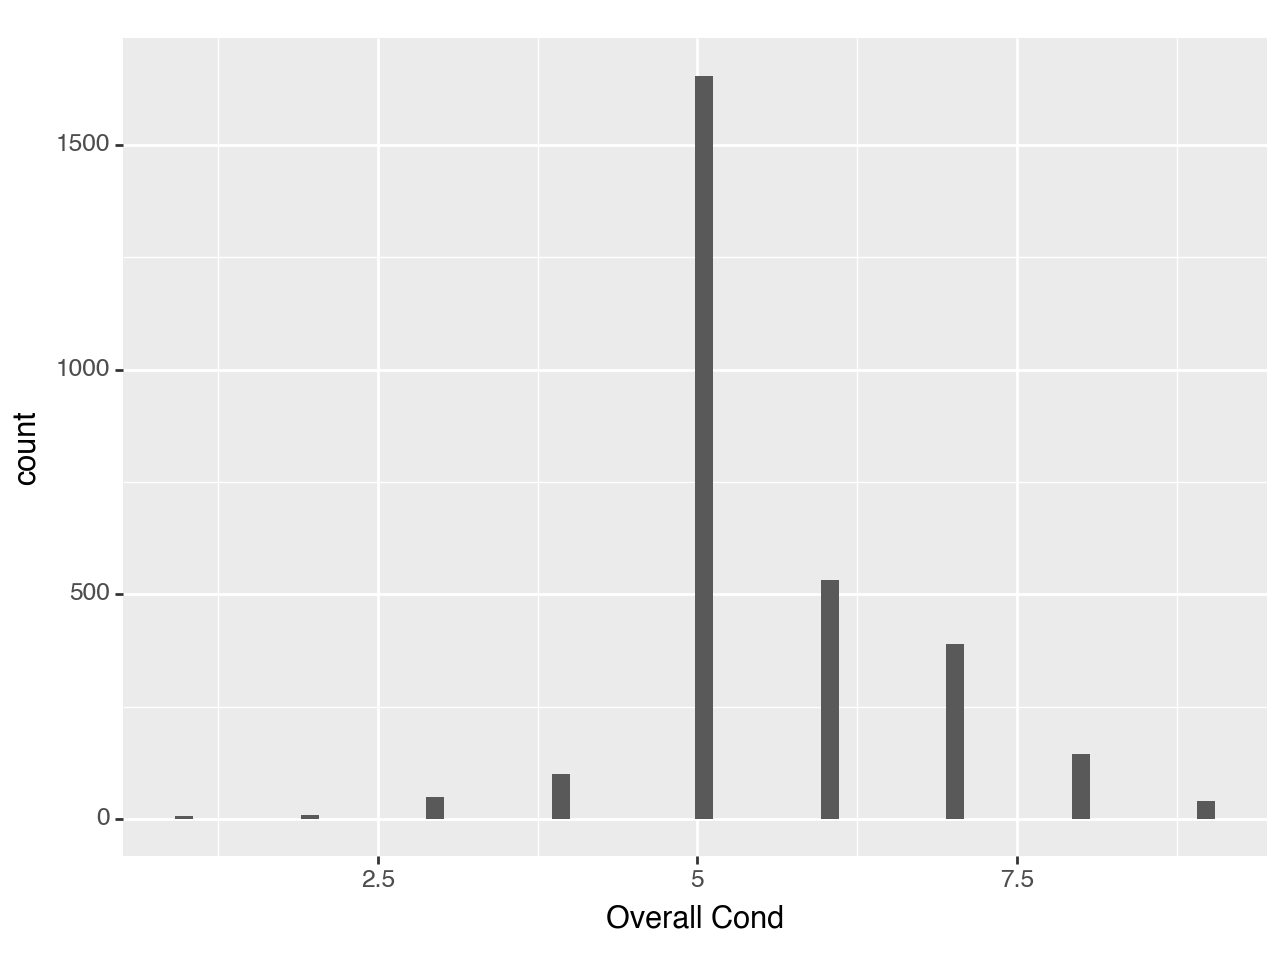

<Figure Size: (640 x 480)>

In [17]:
(
  ggplot(ames_raw)+geom_histogram()+aes(x="Overall Cond")
)

It's important to know which way is better.  For the Ames data it is infact
  10 Very Excellent
  9 Excellent
  8 Very Good
  7 Good
  6 Above Average
  5 Average
  4 Below Average
  3 Fair
  2 Poor
  1 Very Poor

One could convert them into integers since there is explicit ordering.  However, the distribution of the variable is uneven, with many observations at five and very few below 5.  In such a case, combining the categories into three may be better since the data does not seem to have the resolution to understand the ten levels.

/Users/thomas/anaconda3/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 15'. Pick better value with 'binwidth'.


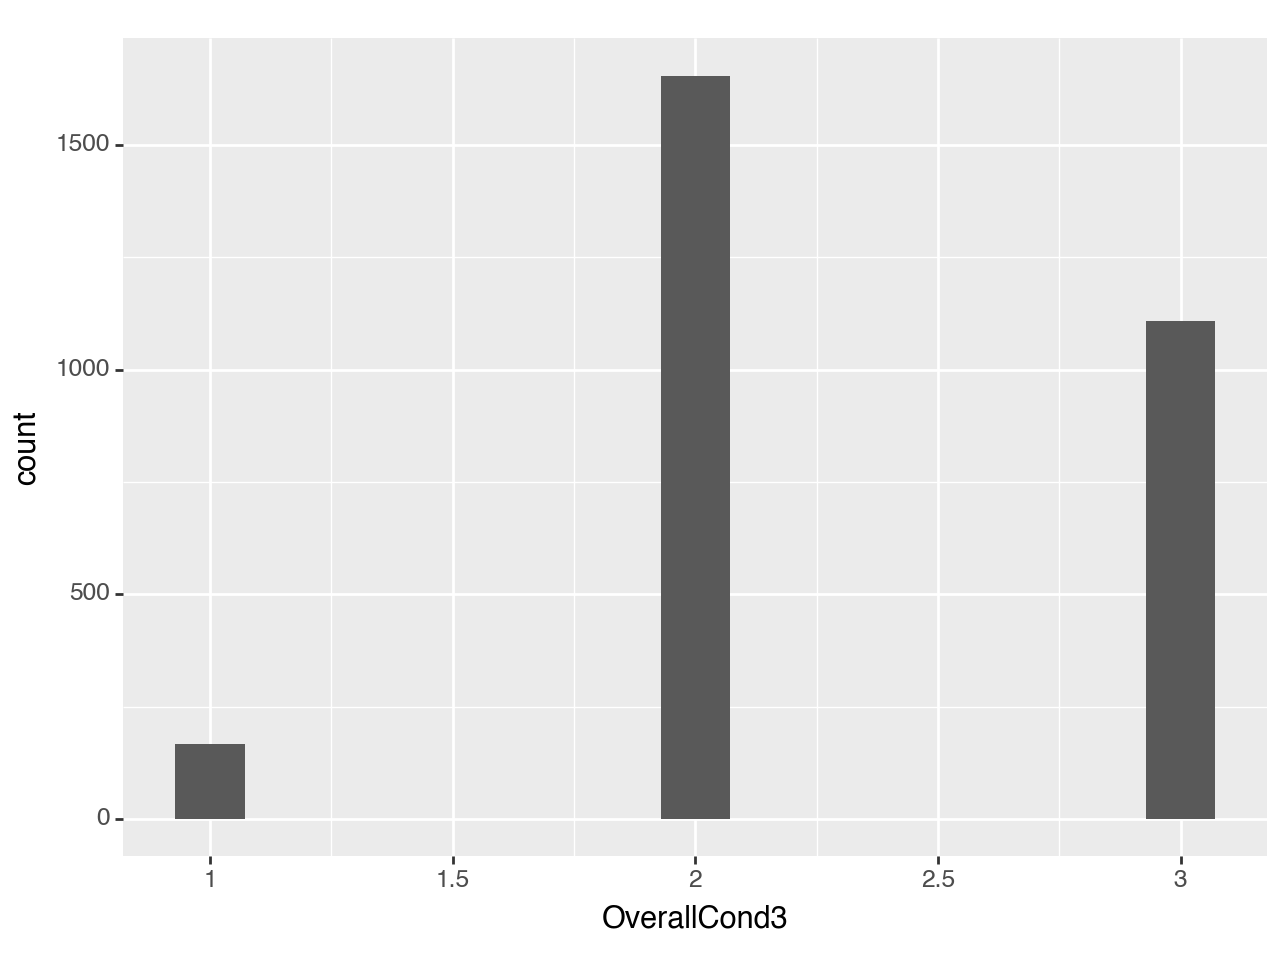

<Figure Size: (640 x 480)>

In [18]:
def if_this_else_that(x, thresh, low, mid, high):
    if x < thresh:
        res = low
    elif x > thresh:
        res = high
    else:
        res = mid
    return(res)

ames_raw["OverallCond3"]= ames_raw["Overall Cond"].apply(lambda x: if_this_else_that(x, 5, 1, 2, 3))
(
  ggplot(ames_raw)+geom_histogram()+aes(x="OverallCond3")
)

### 9. Selecting and compressing

There are various reasons why you need to be selective of what to include.  This could be the lack of information from the variable due to the limitations posed by the sample size, contextual reasons, or overlapping information.

- If there is very small variability in some variable, it's very unlikely that you will get some differetiating information out of them.

For highly correlated variables you might select variables so that correlation does not impact the model building.

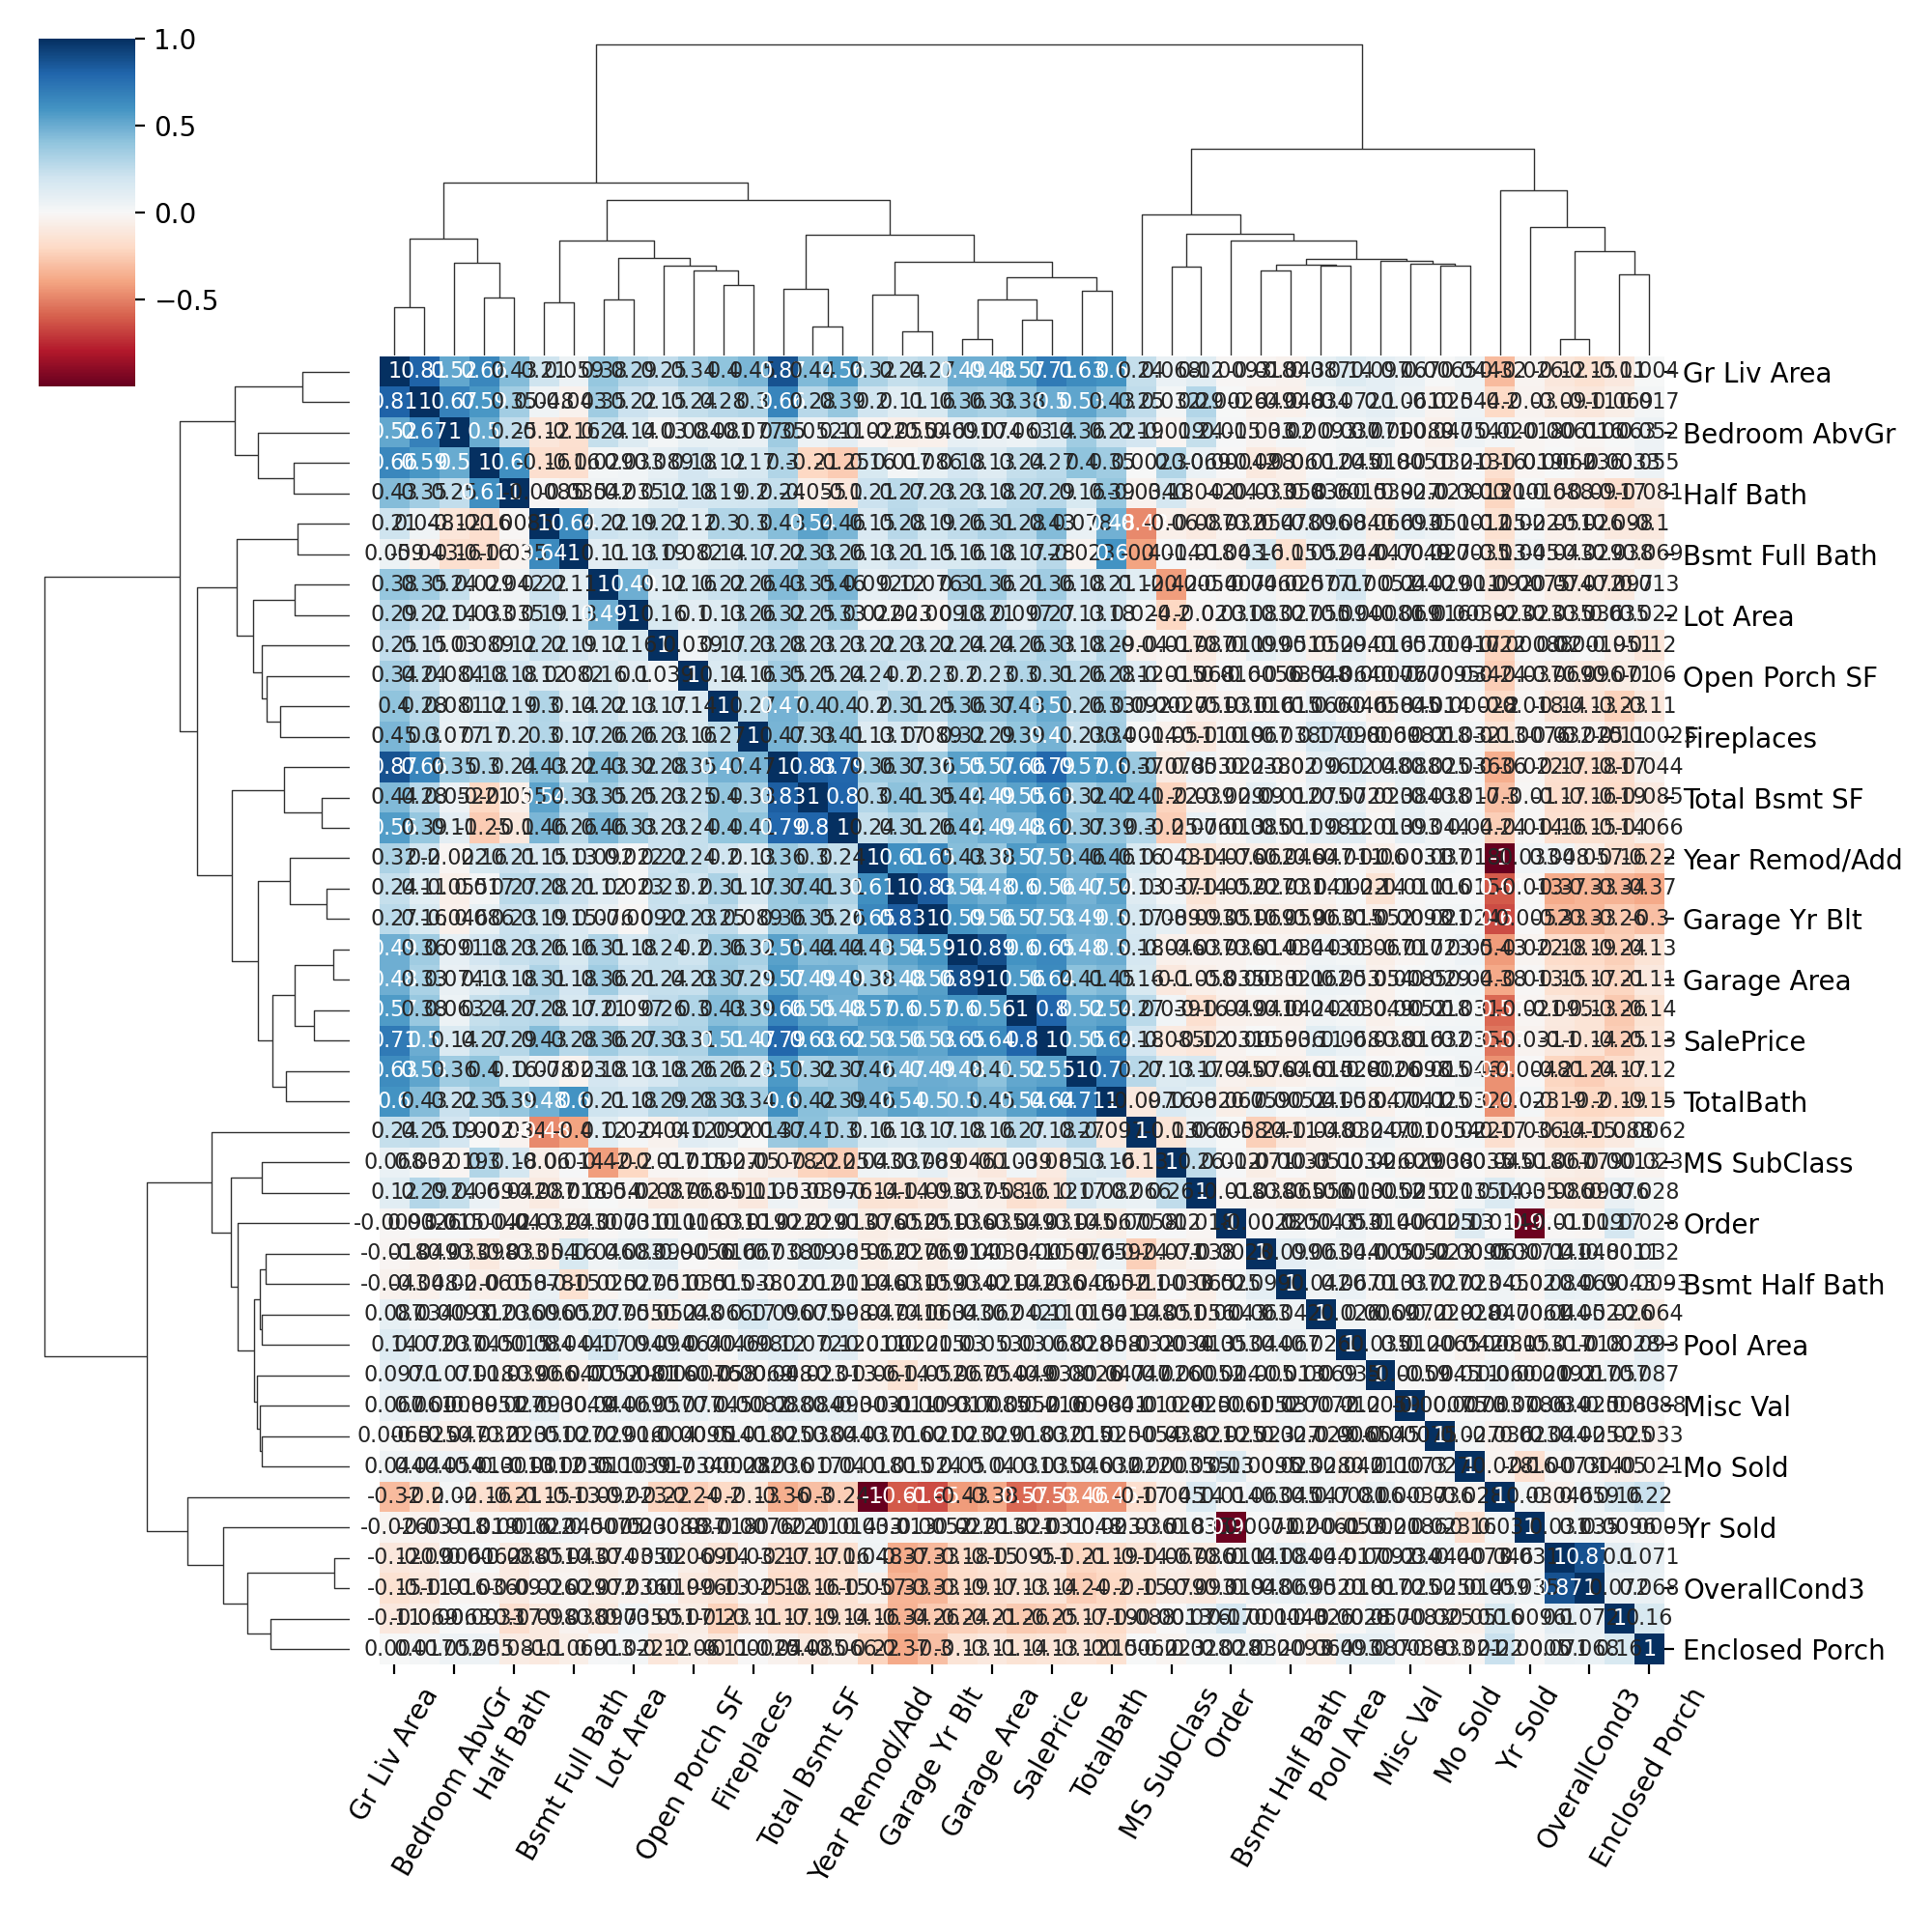

In [19]:
# Correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.clustermap(ames_raw.select_dtypes(include=np.number).corr(),
                   method = 'complete',
                   cmap   = 'RdBu',
                   annot  = True,
                   annot_kws = {'size': 8})
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=60);
plt.show()

Alternatively, you could compress the correlated variable using dimension reduction.  However, it's no free lunch since you need to do all the scaling and missing data processing before you can apply PCA and you need to decide how many components to include.  pcaMethods package offers a way to fit a model even in the presence of missing data.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(ames_raw.select_dtypes(include=np.number))
ames_raw_fill=imp_mean.transform(ames_raw.select_dtypes(include=np.number))
pca = PCA(n_components=20)
pca.fit(ames_raw_fill,20)
print(pca.explained_variance_ratio_)

## In class work

### Model fitting

Since you've worked on it in MA679 please copy and paste your best model here.

In [26]:
lmfit_2008_inter = sm.ols("""
            np.log(SalePrice) ~
            np.log(Q('Gr Liv Area')) + 
            Q('1st Flr SF') +
            Q('Full Bath') +
            Q('Garage Cars') + 
            Q('Garage Area') +
            Q('Total Bsmt SF') +
            Q('Year Built') +
            Q('Year Remod/Add') + 
            Q('TotRms AbvGrd') +
            Q('Garage Area'):Q('Year Built')
            """, ames_raw_2008).fit()
# print(lmfit_2008_inter.summary())
# print(ames_raw_2008.dtypes)
numerical_cols = ames_raw_2008.select_dtypes(include=['int64', 'float64']).columns.tolist()#
categorical_cols = ames_raw_2008.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)



Numerical Columns: ['Order', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'SalePrice']
Categorical Columns: ['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heati

Your answer:

~~~
Please write your answer in full sentences.


~~~

Please perform feature engineering on the Ames housing data that you think will help with the prediction.

In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

X = ames_raw_2008.drop('SalePrice', axis=1)
y = np.log(ames_raw_2008['SalePrice'])

numerical_cols = ['Gr Liv Area', '1st Flr SF', 'Full Bath', 'Garage Cars', 'Garage Area', 'Total Bsmt SF', 'Year Built', 'Year Remod/Add', 'TotRms AbvGrd']

X_numerical = X[numerical_cols]
imputer = SimpleImputer(strategy='median')

X_imputed = imputer.fit_transform(X_numerical)
polynomial_features = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_poly = polynomial_features.fit_transform(X_imputed)
X_poly_df = pd.DataFrame(X_poly, columns=polynomial_features.get_feature_names_out())



In [38]:
from sklearn.pipeline import Pipeline

data_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True))
])

X_poly = data_pipeline.fit_transform(X_numerical)
X_poly_df = pd.DataFrame(X_poly, columns=data_pipeline.named_steps['poly_features'].get_feature_names_out(input_features=numerical_cols))


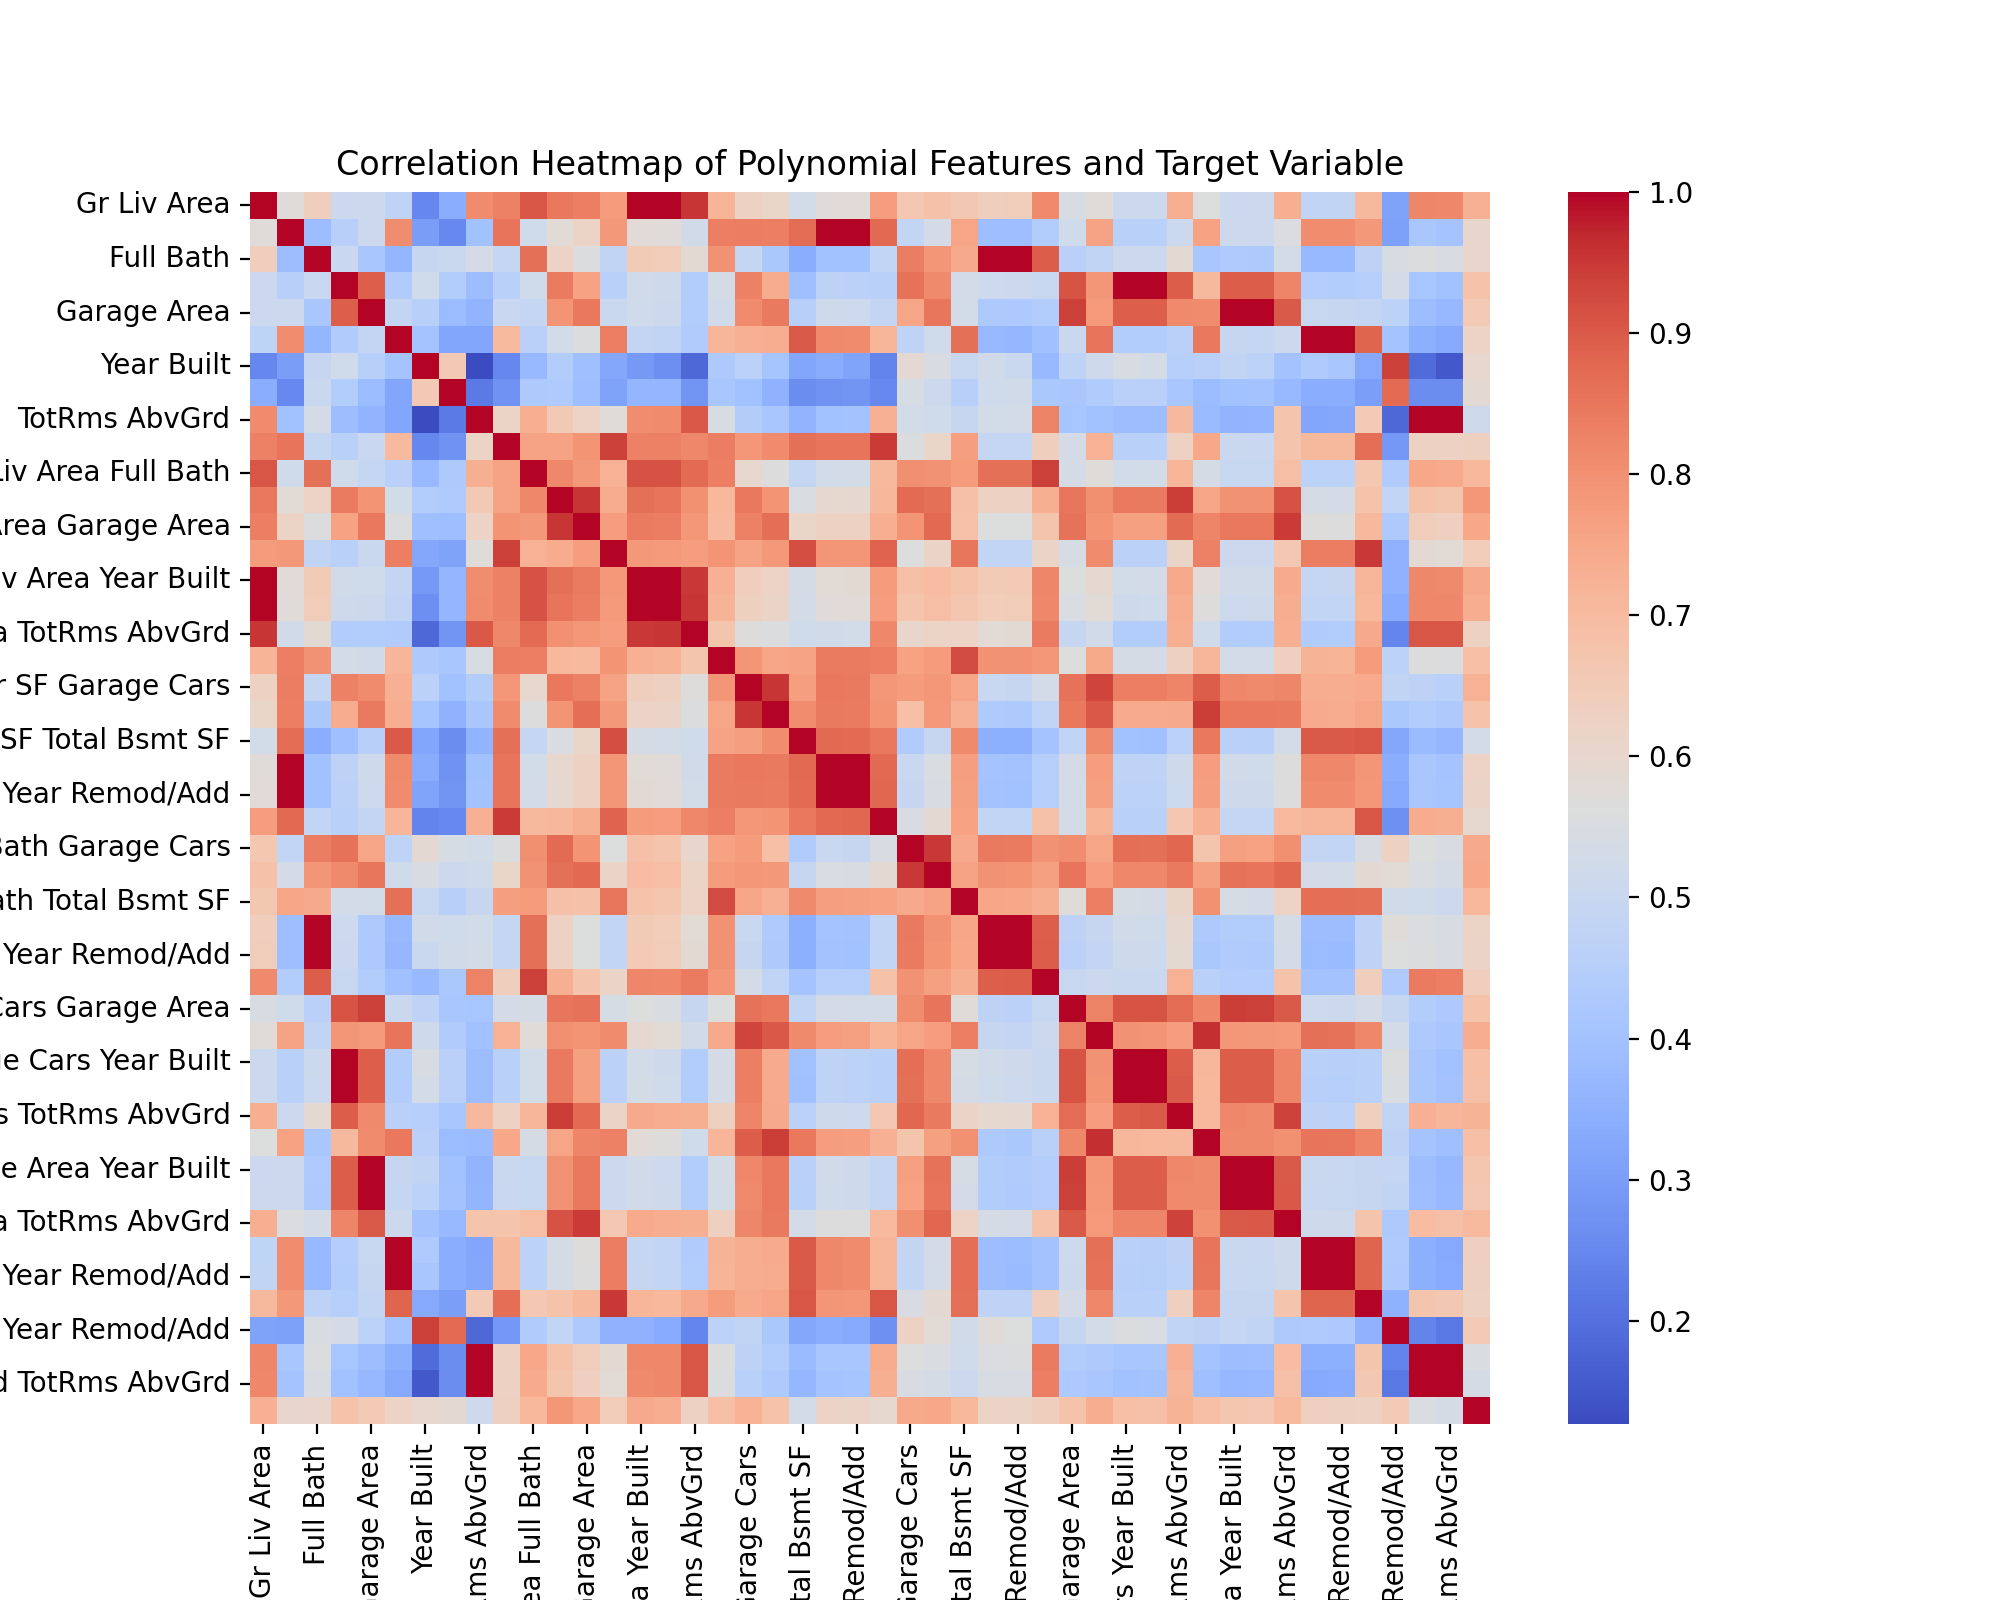

In [39]:
import matplotlib.pyplot as plt

X_poly_df['Target'] = y.reset_index(drop=True)
corr_matrix = X_poly_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title('Correlation Heatmap of Polynomial Features and Target Variable')
plt.show()


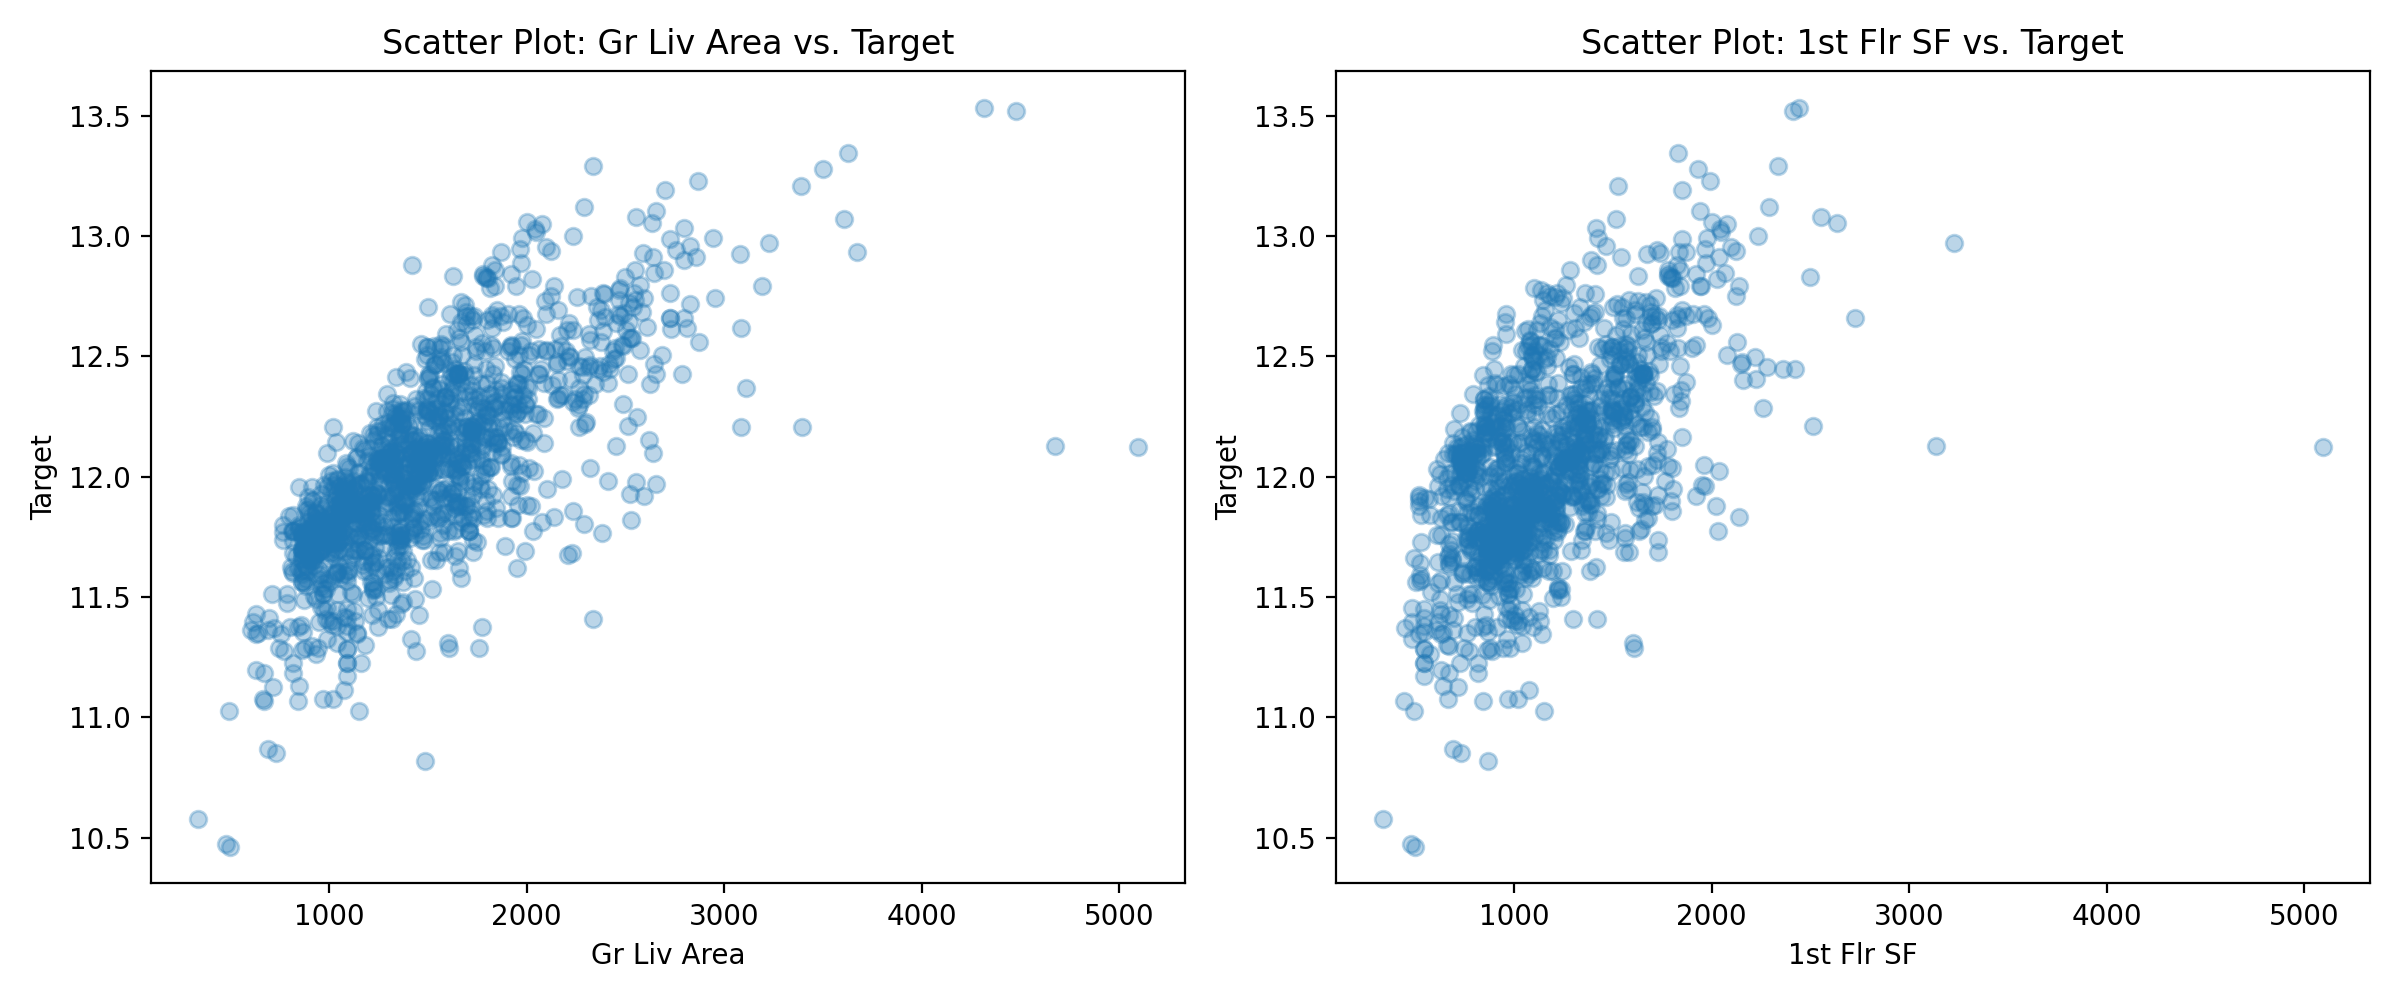

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

for i, col in enumerate(X_poly_df.columns[:2]):
    ax[i].scatter(X_poly_df[col], X_poly_df['Target'], alpha=0.3)
    ax[i].set_title(f'Scatter Plot: {col} vs. Target')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Target')

plt.tight_layout()
plt.show()


Your answer:

~~~
Please write your answer in full sentences.


~~~

Compare the result before and after the feature engineering step.

Your answer:

~~~
Please write your answer in full sentences.


~~~

## AutoML

Feature engineering is mostly about context.  But does it matter if the prediction is of interest?  Is there automatic ways to do all of this that is better?  Let's find out.

Include all the vairables you included as well as anything you want to add to the model.

In [ ]:
vars = ["SalePrice","Lot Area","Gr Liv Area","Full Bath"]
#vars <- c("SalePrice")#

In [ ]:
train_set = ames_raw_2008.loc[:, vars]
test_set  = ames_raw_2009.loc[:, vars]

train_set["SalePrice"] = np.log(train_set["SalePrice"])
test_set["SalePrice"] = np.log(test_set["SalePrice"])

### Pycaret

In [ ]:
# https://michael-fuchs-python.netlify.app/2022/01/15/automl-using-pycaret-regression/
import pycaret.regression  as pycr

summary_preprocess = pycr.setup(train_set,
                                target = 'SalePrice',
                                numeric_features = ["Lot Area","Gr Liv Area","Full Bath"],
                                normalize = True,
                                feature_selection = True,
                                remove_multicollinearity = True)
available_models = pycr.models()
best_reg = pycr.compare_models()
evaluation_best_clf = pycr.evaluate_model(best_reg)

### H2O autoML

h2o autoML is well known in the field as something pretty powerful.
https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html

In [ ]:
import h2o
from h2o.automl import H2OAutoML
localH2O = h2o.init(nthreads = -1, max_mem_size="4g")
# upload the data
train_hf = h2o.H2OFrame(train_set)
test_hf = h2o.H2OFrame(test_set)

aml = H2OAutoML(max_models=10, max_runtime_secs=10,seed=1)
# Train the model
aml.train(x=["Lot Area","Gr Liv Area","Full Bath"], y="SalePrice", training_frame=train_hf)
# Look at the result
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

# The leader model is stored here
aml.leader
preds = aml.leader.predict(test_hf)
# Get the best performing model
m = aml.get_best_model()

# Get the best model using a non-default metric
m = aml.get_best_model(criterion="rmse")

# Get the best XGBoost model using default sort metric
xgb = aml.get_best_model(algorithm="xgboost")

h2o.cluster().shutdown(prompt =False)

### autosklern

I was not able to make autosklearn work on Mac.

In [ ]:
# import autosklearn.regression
# automl = autosklearn.regression.AutoSklearnRegressor(
#     time_left_for_this_task=120,
#     per_run_time_limit=30,
#     tmp_folder="/tmp/autosklearn_regression_example_tmp",
# )
# automl.fit(X_train, y_train, dataset_name="diabetes")

### autoxgboost

XG Boost is a popular implementation of gradient boosting method that we will talk about in MA679.  Leaving aside the detail, it's another popular ML method that has a lot of tuning parameters.  AutoXGBoost is a function that would search for good choice of these parameters automaticall.

I was not able to make autoxgboost work on Mac.

In [ ]:
# load library
# from autoxgb import AutoXGB
#
# train_set.to_csv('train_set.csv', index=False)
# test_set.to_csv('test_set.csv', index=False)
#
# axgb = AutoXGB(
#     train_filename="train_set.csv",
#     output="output",
#     test_filename="test_set.csv",
#     task=None,
#     idx=None,
#     targets=["SalePrice"],
#     features=None,
#     categorical_features=None,
#     use_gpu=False,
#     num_folds=5,
#     seed=123,
#     num_trials=100,
#     time_limit=30,
#     fast=False,
# )
# axgb.train()